In [2]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from math import sqrt
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


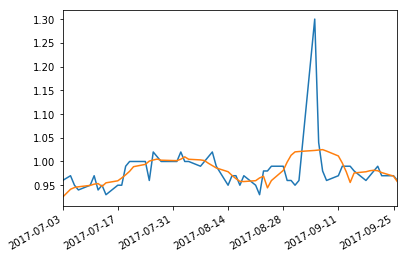

In [8]:
yield_data = pd.read_csv('FRB_H15_NN.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2001-07-31']

##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered = pd.DataFrame(yield_data_filtered,dtype=np.float32)
yield_data = pd.DataFrame(yield_data,dtype=np.float32)

Short-term bonds Prediction.
Add same day yields from other short-term bonds as aux_input

In [3]:
step_size = 20
features_aux = yield_data_filtered[step_size:][['1-month','3-month','6-month','1-year','2-year']]
yield_data_filtered = yield_data_filtered[['1-month','3-month','6-month','1-year','2-year']]


features_20days = np.zeros(((yield_data_filtered.shape[0]-step_size),step_size,yield_data_filtered.shape[1]))

for t in range(features_20days.shape[0]):
    features_20days[t] = yield_data_filtered[t:t+step_size]

labels = yield_data[step_size:].iloc[:,:-2]

In [4]:
from keras.optimizers import Adam
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import keras
def predictLSTM(target,features,features_aux):
    print("******************",target,"***********************")
    seed(1)
    Y=labels[[target]]
    X=features
    features_aux = features_aux.loc[:, features_aux.columns != target]

    y_train=Y[Y.index < '2017-04-01']
    y_test=Y[Y.index  >= '2017-04-01']
    X_train_aux = features_aux[features_aux.index <'2017-04-01']
    X_test_aux = features_aux[features_aux.index >='2017-04-01']
    X_train=X[:y_train.shape[0]]
    X_test = X[y_train.shape[0]:]
    
    index = y_test.index

    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_train_aux.shape,X_test_aux.shape)

    y_train=np.array(y_train)
    y_test=np.array(y_test)
    X_train_aux = np.array(X_train_aux)
    X_test_aux = np.array(X_test_aux)
    
  
    #Model
    main_input = Input(shape=(X_train.shape[1], X_train.shape[2]),name='main_input')
    lstm_out = LSTM(2)(main_input)
    
    auxiliary_input = Input(shape=(X_train_aux.shape[1],),name='aux_input')
    x = keras.layers.concatenate([lstm_out,auxiliary_input])
    x = Dense(3,activation='relu')(x)
    output = Dense(1,name='output')(x)
    model = Model(inputs=[main_input,auxiliary_input],outputs=output)
    
    #Compile Model
    adam = Adam(lr=0.001)
    model.compile(loss='mae',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    
    # fit network
    history = model.fit({'main_input': X_train, 'aux_input': X_train_aux},
                        {'output': y_train},
                        epochs=2000, batch_size=1000, 
                        validation_data=([X_test,X_test_aux], y_test), verbose=0, shuffle=True)
    
    # plot history
    ypred = model.predict([X_test,X_test_aux])
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    print('RMSE=',np.sqrt(mean_squared_error(y_test,ypred)))
    ###plot true and predict
    final=pd.DataFrame()
    
    final['Time']=index
    final.index=index
    final['true']=y_test
    final['pred']=ypred
    plt.figure(figsize=(18, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(18,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
            c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
            c="c", s=s, alpha=a,
            label="LSTM (R2score={:.2f} \n RMSE={:.2f})".format(r2_score(y_test,ypred),
                                                              np.sqrt(mean_squared_error(y_test,ypred))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical', fontsize = 6)
    plt.xlabel("date")
    
    plt.ylabel(target+" yield")
    #plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

****************** 1-month ***********************
(2904, 20, 5) (123, 20, 5) (2904, 1) (123, 1) (2904, 4) (123, 4)


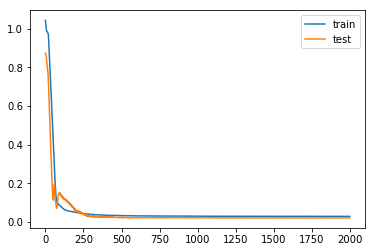

RMSE= 0.0354993


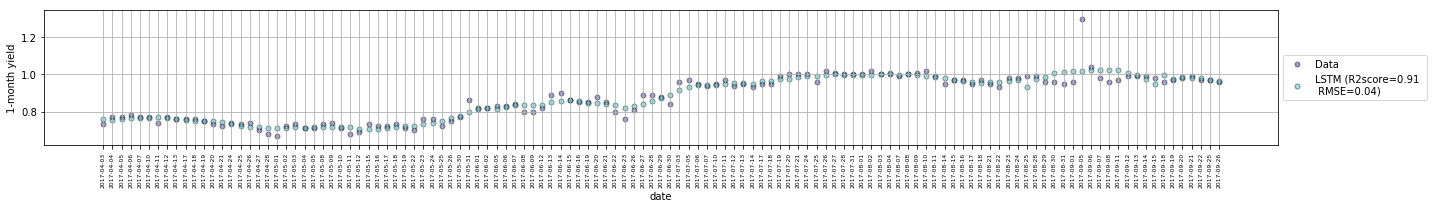

****************** 3-month ***********************
(2904, 20, 5) (123, 20, 5) (2904, 1) (123, 1) (2904, 4) (123, 4)


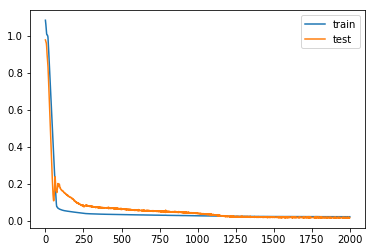

RMSE= 0.0226197


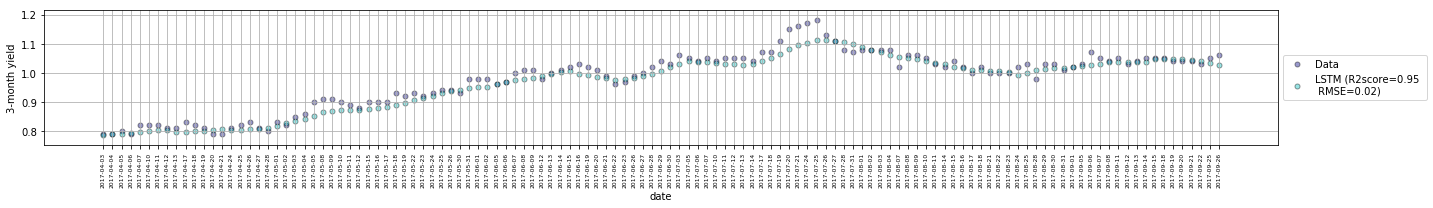

****************** 6-year ***********************


KeyError: "['6-year'] not in index"

In [5]:

for target in ['1-month', '3-month']: 
    predictLSTM(target,features_20days,features_aux)
    

****************** 6-month ***********************
(2904, 20, 5) (123, 20, 5) (2904, 1) (123, 1) (2904, 4) (123, 4)


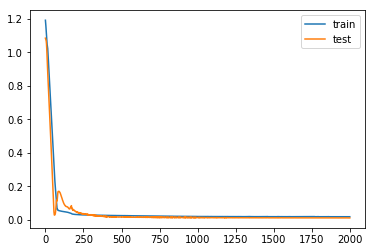

RMSE= 0.0145462


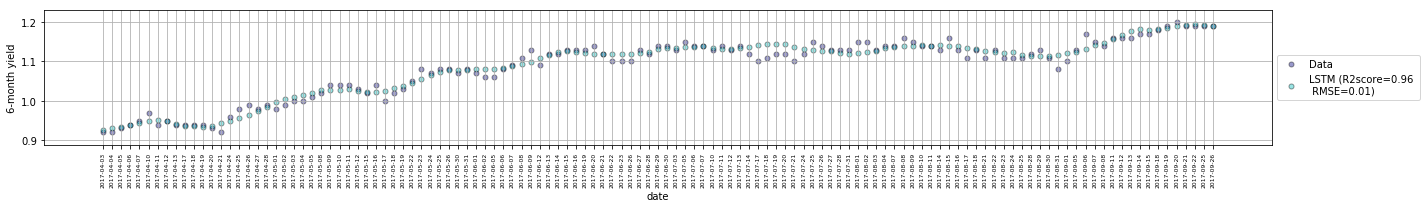

****************** 1-year ***********************
(2904, 20, 5) (123, 20, 5) (2904, 1) (123, 1) (2904, 4) (123, 4)


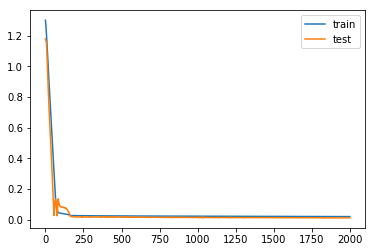

RMSE= 0.0146727


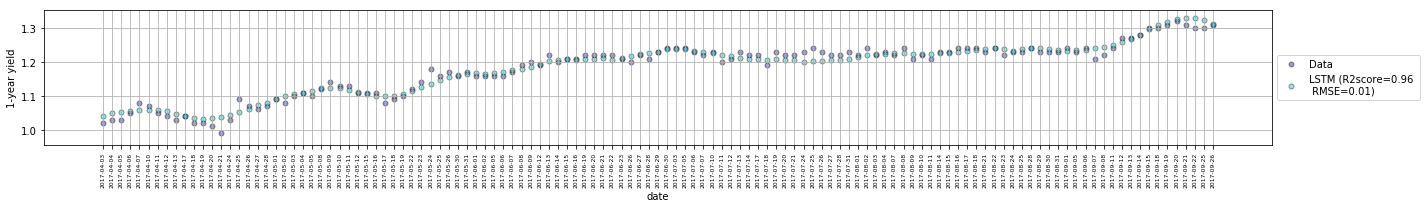

****************** 2-year ***********************
(2904, 20, 5) (123, 20, 5) (2904, 1) (123, 1) (2904, 4) (123, 4)


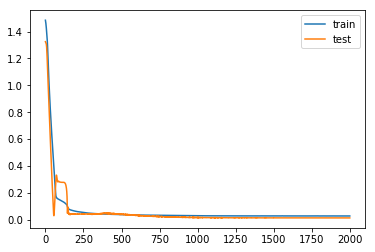

RMSE= 0.0168595


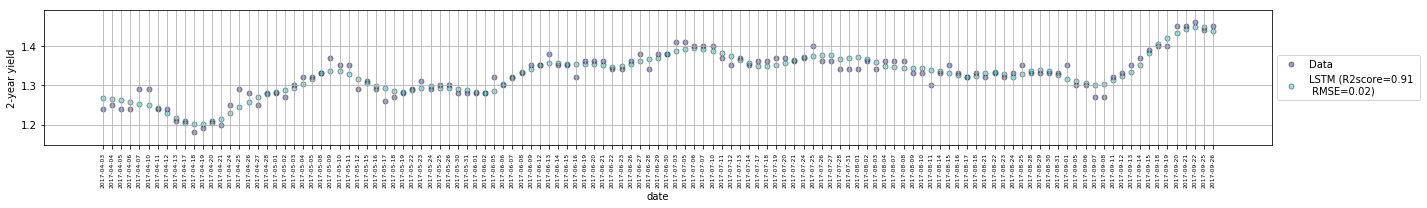

In [6]:

for target in ['6-month', '1-year','2-year']: 
    predictLSTM(target,features_20days,features_aux)
    

Long-term bonds prediction, use step size =10 

In [9]:
step_size = 10
features_aux = yield_data_filtered[step_size:][['3-year','5-year','7-year','10-year','20-year','30-year']]
yield_data_filtered = yield_data_filtered[['3-year','5-year','7-year','10-year','20-year','30-year']]


features_20days = np.zeros(((yield_data_filtered.shape[0]-step_size),step_size,yield_data_filtered.shape[1]))

for t in range(features_20days.shape[0]):
    features_20days[t] = yield_data_filtered[t:t+step_size]

labels = yield_data[step_size:].iloc[:,:-2]

****************** 3-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


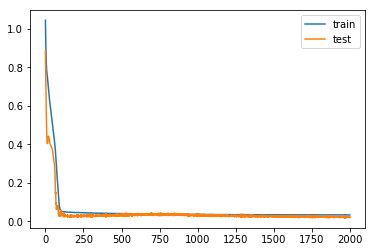

RMSE= 0.0253286


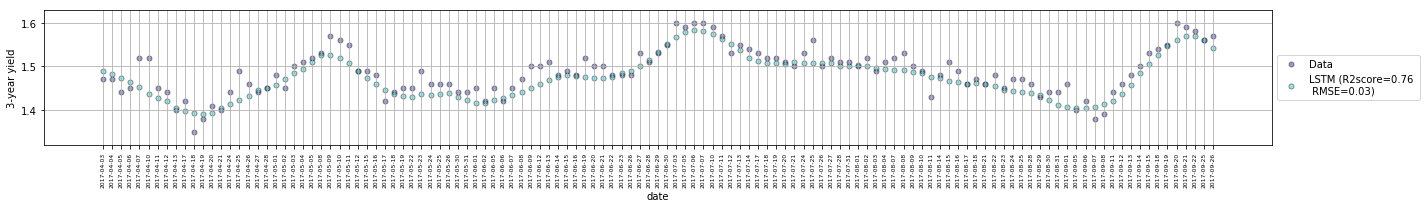

In [10]:
predictLSTM('3-year',features_20days,features_aux)

****************** 5-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


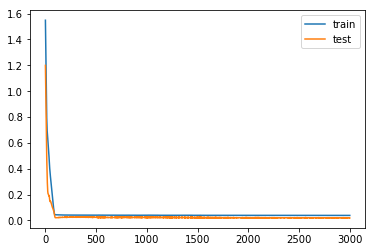

RMSE= 0.0257138


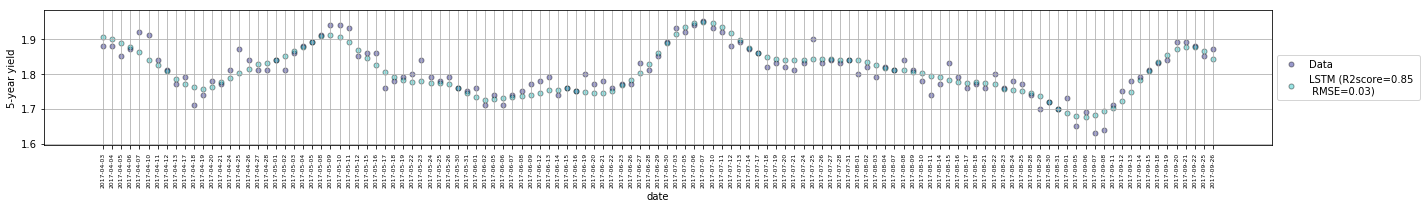

In [12]:
predictLSTM('5-year',features_20days,features_aux)

****************** 7-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


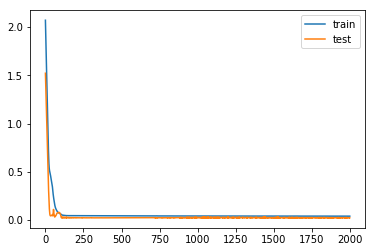

RMSE= 0.0271999


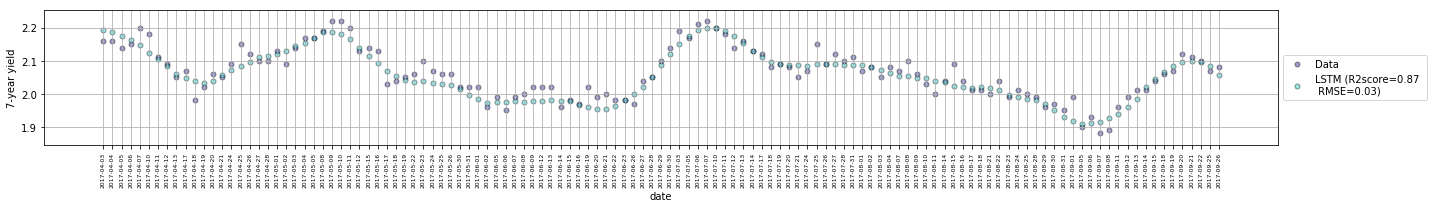

****************** 10-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


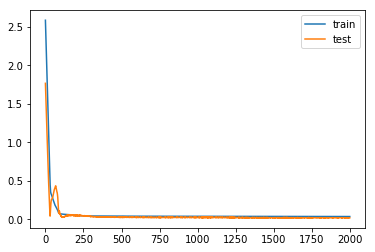

RMSE= 0.0267382


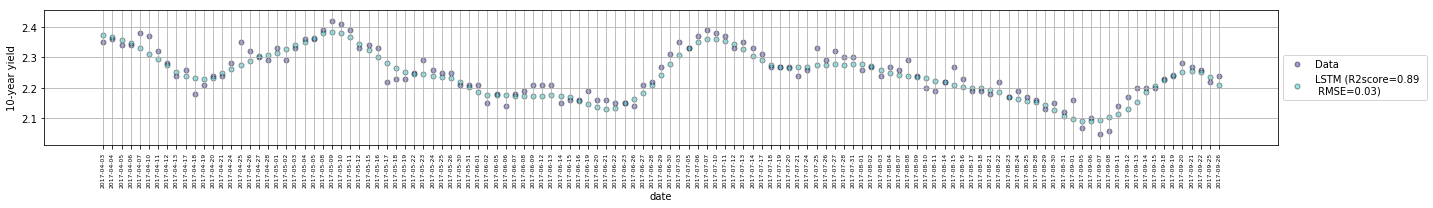

****************** 20-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


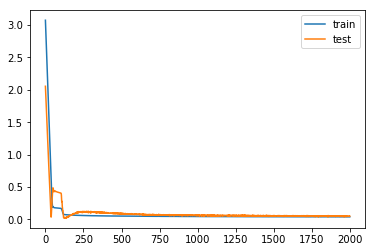

RMSE= 0.0558742


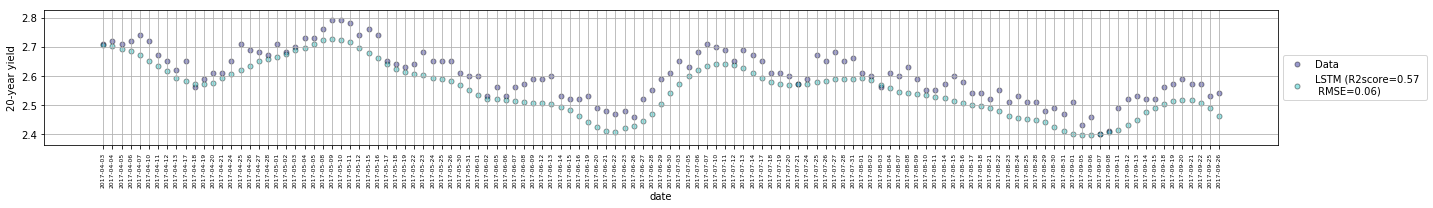

****************** 30-year ***********************
(2914, 10, 6) (123, 10, 6) (2914, 1) (123, 1) (2914, 5) (123, 5)


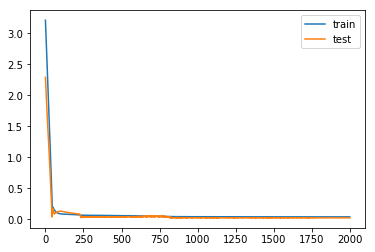

RMSE= 0.0270269


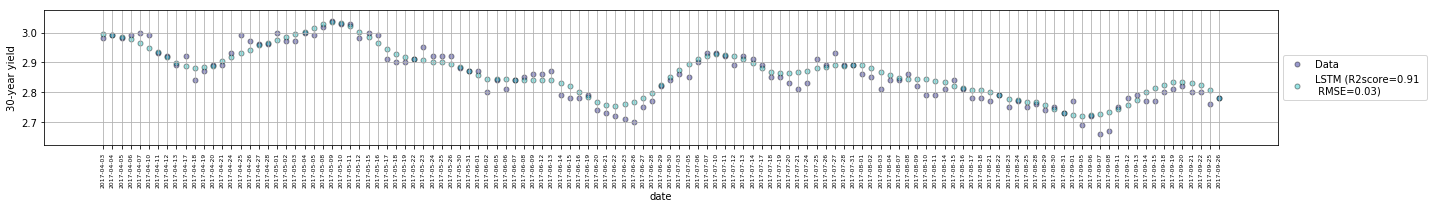

In [14]:
for target in ['7-year','10-year','20-year','30-year']: 
    predictLSTM(target,features_20days,features_aux)

Compare with the ARIMA baseline

In [3]:
yield_data = pd.read_csv('FRB_H15_NN.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >='2000-01-01']

##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data_filtered = pd.DataFrame(yield_data_filtered,dtype=np.float32)
yield_data = pd.DataFrame(yield_data,dtype=np.float32)


step_size = 20
features_aux = yield_data_filtered[step_size:][['1-month','3-month','6-month','1-year','2-year']]
yield_data_filtered = yield_data_filtered[['1-month','3-month','6-month','1-year','2-year']]


features_20days = np.zeros(((yield_data_filtered.shape[0]-step_size),step_size,yield_data_filtered.shape[1]))

for t in range(features_20days.shape[0]):
    features_20days[t] = yield_data_filtered[t:t+step_size]

labels = yield_data[step_size:].iloc[:,:-2]

from keras.optimizers import Adam
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import keras
def predictLSTM(target,features,features_aux):
    print("******************",target,"***********************")
    seed(1)
    Y=labels[[target]]
    X=features
    features_aux = features_aux.loc[:, features_aux.columns != target]

    y_train=Y[Y.index <= '2016-12-31']
    y_test=Y[Y.index  >= '2017-01-01']
    X_train_aux = features_aux[features_aux.index <= '2016-12-31']
    X_test_aux = features_aux[features_aux.index  >= '2017-01-01']
    X_train=X[:y_train.shape[0]]
    X_test = X[y_train.shape[0]:]
    
    index = y_test.index

    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_train_aux.shape,X_test_aux.shape)

    y_train=np.array(y_train)
    y_test=np.array(y_test)
    X_train_aux = np.array(X_train_aux)
    X_test_aux = np.array(X_test_aux)
    
  
    #Model
    main_input = Input(shape=(X_train.shape[1], X_train.shape[2]),name='main_input')
    lstm_out = LSTM(2)(main_input)
    
    auxiliary_input = Input(shape=(X_train_aux.shape[1],),name='aux_input')
    x = keras.layers.concatenate([lstm_out,auxiliary_input])
    x = Dense(3,activation='relu')(x)
    output = Dense(1,name='output')(x)
    model = Model(inputs=[main_input,auxiliary_input],outputs=output)
    
    #Compile Model
    adam = Adam(lr=0.001)
    model.compile(loss='mae',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    
    # fit network
    history = model.fit({'main_input': X_train, 'aux_input': X_train_aux},
                        {'output': y_train},
                        epochs=2000, batch_size=1000, 
                        validation_data=([X_test,X_test_aux], y_test), verbose=0, shuffle=True)
    
    # plot history
    ypred = model.predict([X_test,X_test_aux])
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    print('RMSE=',np.sqrt(mean_squared_error(y_test,ypred)))
    ###plot true and predict
    final=pd.DataFrame()
    
    final['Time']=index
    final.index=index
    final['true']=y_test
    final['pred']=ypred
    plt.figure(figsize=(18, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(18,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
            c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
            c="c", s=s, alpha=a,
            label="LSTM (R2score={:.2f} \n RMSE={:.2f})".format(r2_score(y_test,ypred),
                                                              np.sqrt(mean_squared_error(y_test,ypred))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical', fontsize = 6)
    plt.xlabel("date")
    
    plt.ylabel(target+" yield")
    #plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

****************** 1-year ***********************
(2843, 20, 5) (185, 20, 5) (2843, 1) (185, 1) (2843, 4) (185, 4)


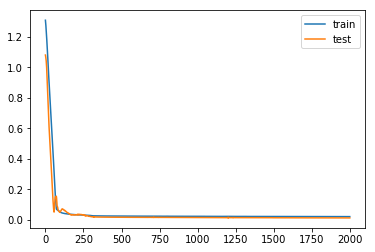

RMSE= 0.0153746


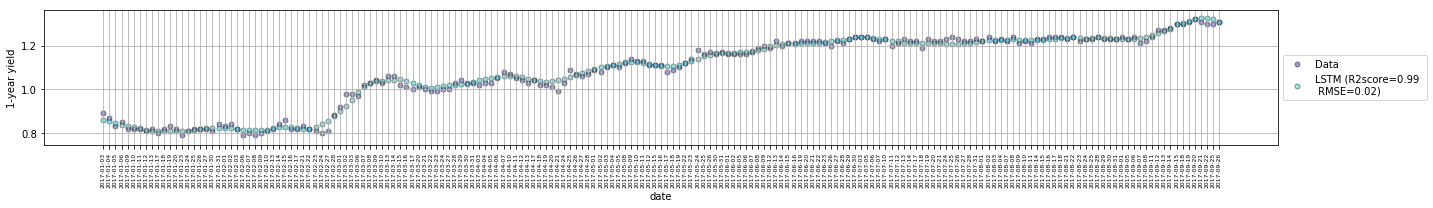

In [4]:
predictLSTM('1-year',features_20days,features_aux)

Better than ARIMA baseline's RMSE:  0.0177426921576

Short-term bonds perform better than long-term, and some long-term better than random forest baseline. 

****************** 1-month ***********************
(2843, 20, 5) (185, 20, 5) (2843, 1) (185, 1) (2843, 4) (185, 4)


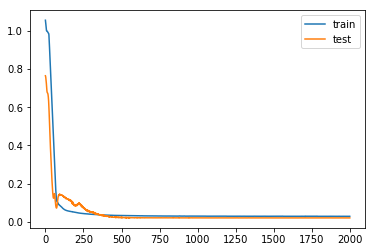

RMSE= 0.0338785


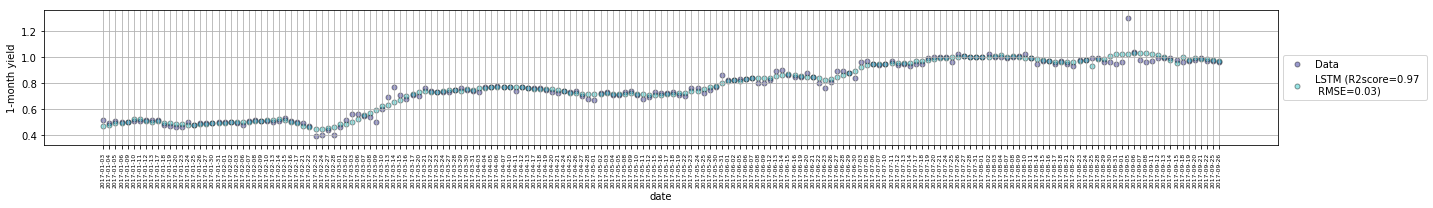

In [5]:
predictLSTM('1-month',features_20days,features_aux)